# 3rd Down Analysis: Weeks {0}-{1}

This is an automated IPython Notebook that displays 3rd Down Performance over the selected weeks built using BurntSushi's NflGame project.  You can select week numbers by tweaking the start and end values in the URL.  

You can use these visualizations to get a better understanding of how each team has been performing.  You can also see the code used to build this by clicking on the visualizations or where prompted to click, so you can use this workbook as a starting place towards your future analyses. 

For an example of how I used this notebook to better understand the Eagles third down performance earlier in the season, [click here](/adhoc?art=EaglesO).

In [57]:
#Import necessary Python Packages. 
import requests
import re
from bs4 import BeautifulSoup
import nflgame
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random
from matplotlib.ticker import FuncFormatter
import matplotlib.image as mpimg
from PIL import Image
from pylab import *
import urllib, cStringIO
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, \
     AnnotationBbox
import pickle
import warnings
warnings.simplefilter(action = "ignore")

pkl_file = open('logos.pkl', 'rb')
logos= pickle.load(pkl_file)



#This function grabs team logo
def getTeamlogo(team, logos=logos):
        return [k for k in logos if k.find(team.lower())!=-1][0]

    #USED TO PUT LOGOS ON GRAPH

def teamlabel():
    file1 = cStringIO.StringIO(urllib.urlopen(getTeamlogo(label.lower())).read())
    img = Image.open(file1)
    imagebox = OffsetImage(img, zoom=.35, alpha=.75)
    ab = AnnotationBbox(imagebox, xy=(x, y),pad=0)
    plt.gca().add_artist(ab)
    

#......A bunch of things to make the graphs below nice.............................

#Display Graphs
%matplotlib inline

#Set canvas for Graphs
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})


#This is a function I use to put percentages on the y-axis of graphs below (Stackoverflow)
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] == True:
        return s + r'$\%$'
    else:
        return s + '%'

formatter = FuncFormatter(to_percent)

    
print "Click here for initializaliton code. (Graphics and Import Statements)"

Click here for initializaliton code. (Graphics and Import Statements)


In [53]:
#Grab all plays from games in Week {0}-{1}, 2015
games = nflgame.games(2015, week=list(arange(1,5)))
plays = nflgame.combine_plays(games)

#Build a Dataset with all 3rd down plays out of the set of plays built above
columns=["team", "ytg", "success", "rush", "patt", "playdescription","home", "away"]

df = pandas.DataFrame(columns=columns)

for p in plays.filter(down=3):
    tempdf = pandas.DataFrame([[p.team, p.yards_togo, p.first_down, p.rushing_att, 
                                p.passing_att,p,p.drive.game.away,p.drive.game.home]]
                              ,columns=columns)
    df = df.append(tempdf, ignore_index=True)

#Remove No Plays and FGs 
df=df[~df["playdescription"].astype("str").str.contains("No Play")]
df=df[~df["playdescription"].astype("str").str.contains("field goal")]

#Set few odd plays where success ==2 to 1, to indicate a successful 3rd down conversion.
df.set_value(df[df['success']==2].index, 'success', 1)

#Create Defense Column
df["defense"]=df["home"]
df.defense[df["team"]==df["home"]]=df["away"]

print "Click Here to see the actual NFL Data Import Code."

Click Here to see the actual NFL Data Import Code.


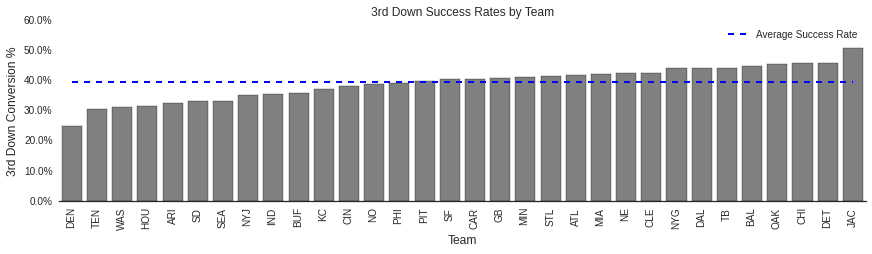

In [65]:
#Build table that shows 3rd down rate by team
third=df.pivot_table(index='defense', values='success', aggfunc=[np.sum, len,np.mean])
third.columns=["Conversions", "Attempts", "Conv_Rate"]
third.sort("Conv_Rate", ascending=True, inplace=True)

sns.set_context({"figure.figsize": (18, 10)})
#............Plot the third down rate by team....................
plt.figure()

g = sns.factorplot(x=third.index, y="Conv_Rate", data=third, aspect=3,kind='bar',
                  color="gray")
g.set_xticklabels(rotation=90)

sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3rd Down Conversion %", fontsize=12)
plt.gca().set_xlabel("Team", fontsize=12)

plt.plot(np.ones(32)*df["success"].mean(),lw=2, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("3rd Down Success Rates by Team")
plt.legend()

plt.show()

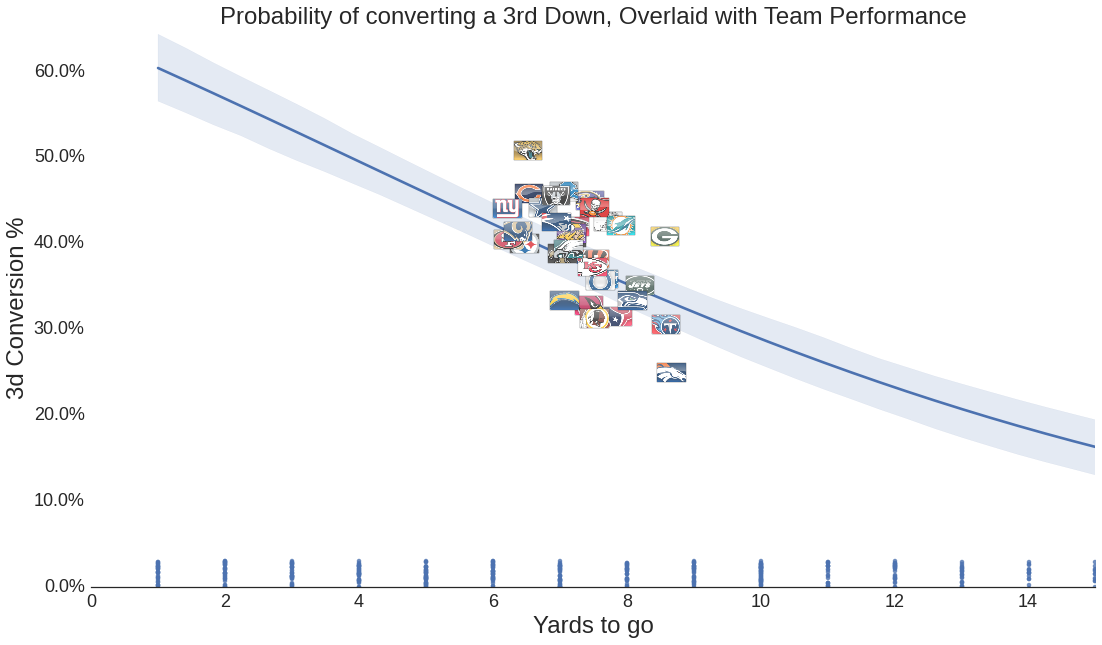

In [62]:
#Build a Series with avg ytg for each team
avgdist=df.pivot_table(index='defense', values='ytg', aggfunc=np.mean)
avgdist=avgdist.sort_index()
avgdist.name="avgdist"

third=third.sort_index()

#Plot third down performance by team vs. logistic regression expectation
sns.set_context({"figure.figsize": (18, 10)})
plt.figure()

sns.regplot(x="ytg", y="success",data=df,logistic=True, y_jitter=.03, truncate=True )
plt.scatter(x=avgdist, y=third["Conv_Rate"], color="red")
plt.xlim(0,15)
plt.ylim(0,.65)

sns.despine(left=True)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.title("Probability of converting a 3rd Down, Overlaid with Team Performance", 
          fontsize=24)
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("3d Conversion %", fontsize=24)
plt.gca().set_xlabel("Yards to go", fontsize=24)

for label, x, y in zip(avgdist.index, 
                       avgdist, 
                       third["Conv_Rate"]):
    teamlabel()
    

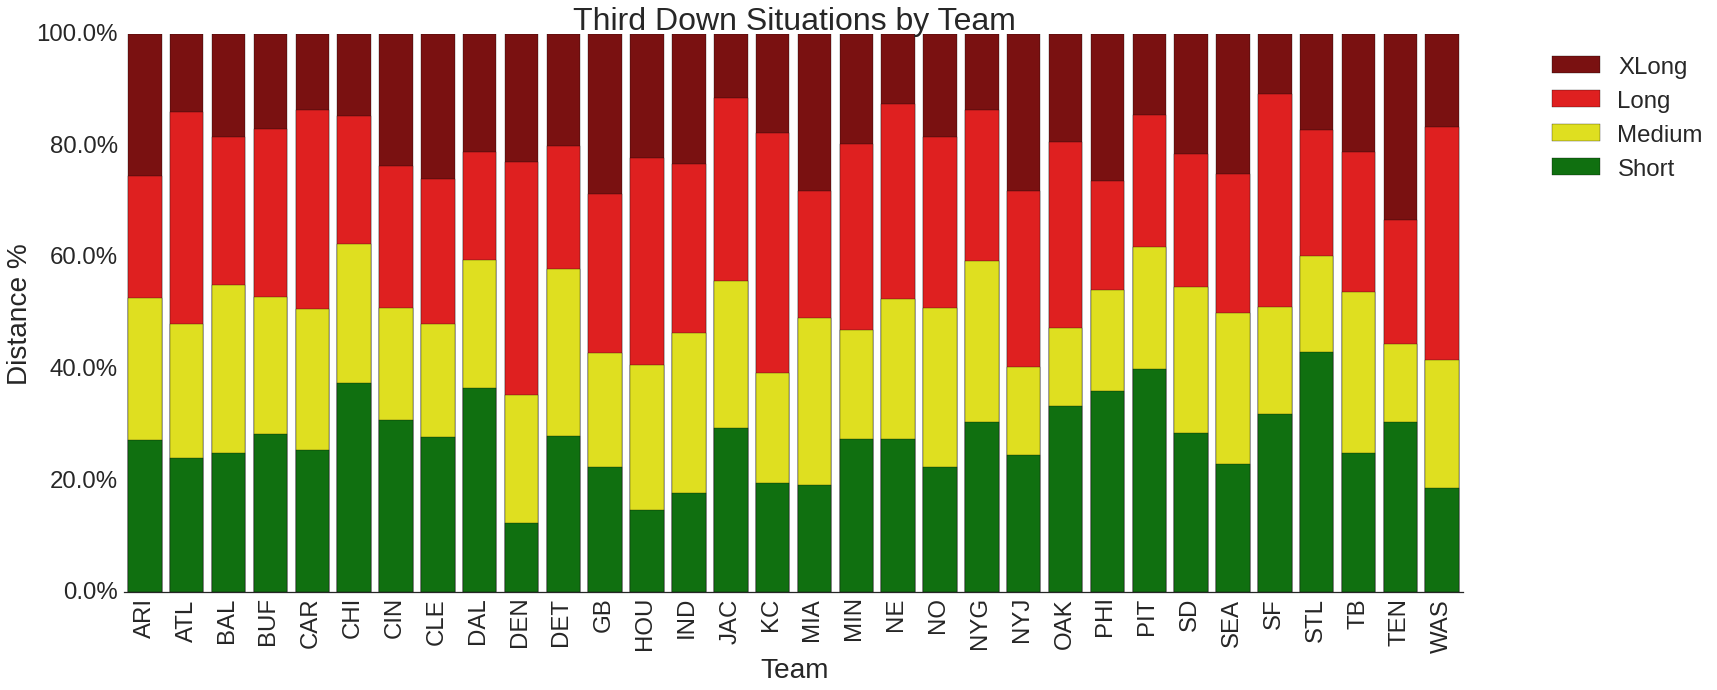

In [66]:
labels=['short','mid','long','long+']

#Build distance buckets for 3rd down distance
df['ytgBuckets']=pandas.cut(df.ytg, [0,3,6,10,50], right=True, labels=labels,retbins=False,
                            precision=3, include_lowest=False).astype("str")

distfreq=df.pivot_table(index='defense', columns='ytgBuckets', values='success', aggfunc=len)
distfreq=distfreq[labels]
distfreq=distfreq.divide(distfreq.sum(axis=1), axis='rows')

#Build graph to show Expect 3rd Down rankings.
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

sns.barplot(x = distfreq.index , y = distfreq.sum(axis=1), color = "darkred", label="XLong")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-1]].sum(axis=1), 
            color = "red", label="Long")
sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-2]].sum(axis=1), 
            color = "yellow", label="Medium")
bottom_plot=sns.barplot(x = distfreq.index , y = distfreq[distfreq.columns[:-3]].sum(axis=1), 
            color = "green", label="Short")
sns.despine(left=True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title("Third Down Situations by Team", fontsize=32)
bottom_plot.set_ylabel("Distance %", fontsize=28)
bottom_plot.set_xlabel("Team", fontsize=28)
plt.xticks(fontsize=24, rotation=90)
plt.yticks(fontsize=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':24})

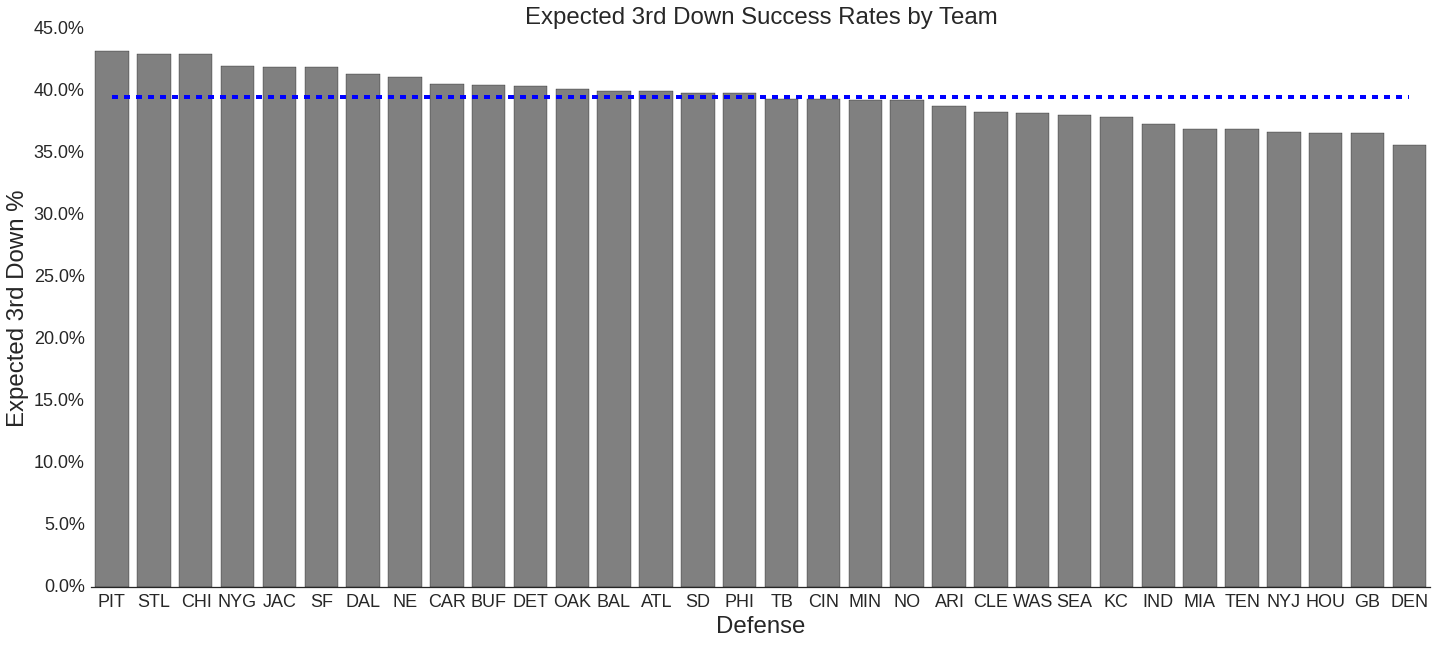

In [67]:
#Table that shows third down attempts and rate by team and distance
#thirdytg=df.pivot_table(index='team', columns='ytgBuckets', values='success', aggfunc=[len,  np.mean])

#NFL 3rd down rates by distance
lenmeans=df.pivot_table(columns='ytgBuckets', values='success', aggfunc=np.mean)
e3d=distfreq.multiply(
    lenmeans, axis=1).sum(axis=1)

e3d.name="e3d"
try:
    third=third.join(e3d)

except:
    pass

third['expsuccess']=third['Attempts'] * third['e3d']
third.sort('e3d', inplace=True, ascending=False)
plt.plot(np.ones(32)*df["success"].mean(),lw=4, color="blue",linestyle="--", 
         label="Average Success Rate")
plt.title("Expected 3rd Down Success Rates by Team", fontsize=24)

sns.despine(left=True)
sns.barplot(x = third.index , y = third.e3d, color="gray")
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().set_ylabel("Expected 3rd Down %", fontsize=24)
plt.gca().set_xlabel("Defense", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

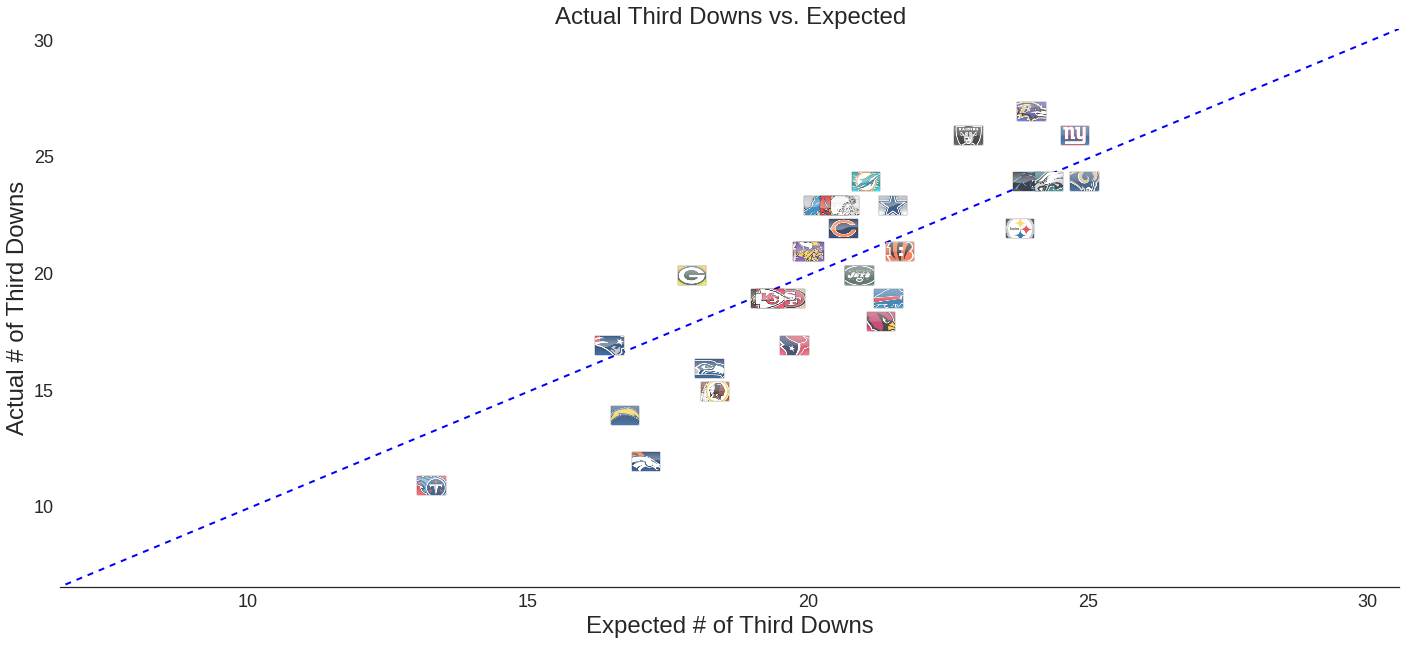

In [68]:
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

g=plt.scatter(x=third.expsuccess, y=third.Conversions, s=200, c="red")

plt.plot(np.arange(0,70,1),lw=2, color="blue",linestyle="--", label="Average Success Rate")

plt.axis([third.expsuccess.min()/2,third.expsuccess.max()+5,\
          third.expsuccess.min()/2,third.expsuccess.max()+5])
plt.title("Actual Third Downs vs. Expected", fontsize=24)
plt.xlabel("Expected # of Third Downs", fontsize=24)
plt.ylabel("Actual # of Third Downs", fontsize=24)
sns.despine(left=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for label, x, y in zip(third.index, 
                       third["expsuccess"], 
                       third["Conversions"]):
    teamlabel()